In [50]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [43]:
df = pd.read_csv('../tmp/stockMarketPrediction_DL/tse_en.csv')

In [44]:
df.describe(include='all')

,Date,Symbol,Name,Yesterday,Open,Last,Close,Close Changes,Low,High,Number Traded,Volume,Value Traded
count,819252,819252,819252,8.192520e+05,8.192520e+05,8.192520e+05,8.192520e+05,8.192520e+05,8.192520e+05,8.192520e+05,8.192520e+05,8.192520e+05,8.192520e+05
unique,3014,1623,856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2021-03-02,سفارس,فولاد مباركه اصفهان,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,452,2879,3150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2.563001e+04,2.549379e+04,2.551777e+04,2.560199e+04,-2.801844e+01,2.501161e+04,2.596804e+04,7.782912e+02,7.063956e+06,4.927777e+10
std,NaN,NaN,NaN,1.072934e+05,1.071701e+05,1.073255e+05,1.074850e+05,8.504582e+03,1.055301e+05,1.090801e+05,1.763309e+04,7.773255e+07,4.231682e+11
min,NaN,NaN,NaN,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-6.407145e+06,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
25%,NaN,NaN,NaN,1.951000e+03,1.939000e+03,1.933000e+03,1.938000e+03,-3.600000e+01,1.901000e+03,1.963000e+03,1.500000e+01,3.993175e+04,1.710529e+08
50%,NaN,NaN,NaN,3.979000e+03,3.950000e+03,3.938000e+03,3.952000e+03,0.000000e+00,3.877000e+03,3.999000e+03,7.800000e+01,3.466635e+05,1.350338e+09
75%,NaN,NaN,NaN,1.079000e+04,1.070000e+04,1.070000e+04,1.072900e+04,4.700000e+01,1.050400e+04,1.084400e+04,3.580000e+02,2.169185e+06,1.150776e+10


In [45]:
khodro = df[df.Symbol == "خودرو"]
khodro.index = pd.to_datetime(khodro['Date'])

In [46]:
khodro = khodro.drop(columns=['Symbol', 'Name', 'Date']).dropna()

In [47]:
"""khodro['MA50'] = khodro['Open'].rolling(50).mean()
khodro['MA200'] = khodro['Open'].rolling(200).mean()
khodro[['Open', 'MA50', 'MA200']].plot(label = 'khodro', figsize = (16,8))"""

"khodro['MA50'] = khodro['Open'].rolling(50).mean()\nkhodro['MA200'] = khodro['Open'].rolling(200).mean()\nkhodro[['Open', 'MA50', 'MA200']].plot(label = 'khodro', figsize = (16,8))"

In [52]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

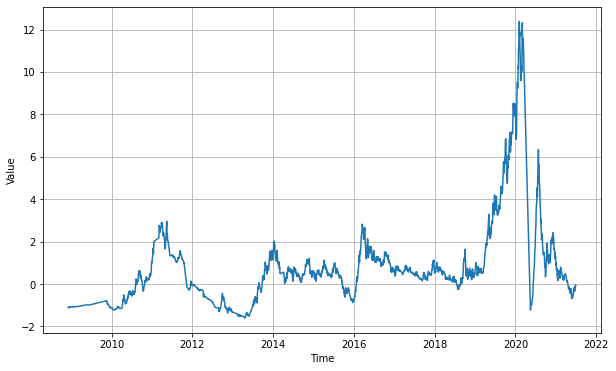

In [54]:
series = khodro['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(khodro.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [55]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [56]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [57]:
tf.keras.backend.clear_session()

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
16/16 [==============================] - 5s 38ms/step - loss: 38.4671 - mae: 38.9622
Epoch 2/100
16/16 [==============================] - 1s 38ms/step - loss: 38.1822 - mae: 38.6765
Epoch 3/100
16/16 [==============================] - 1s 29ms/step - loss: 37.7958 - mae: 38.2895
Epoch 4/100
16/16 [==============================] - 1s 27ms/step - loss: 37.3560 - mae: 37.8493
Epoch 5/100
16/16 [==============================] - 1s 28ms/step - loss: 36.8719 - mae: 37.3655
Epoch 6/100
16/16 [==============================] - 1s 31ms/step - loss: 36.3404 - mae: 36.8341
Epoch 7/100
16/16 [==============================] - 1s 31ms/step - loss: 35.7612 - mae: 36.2542
Epoch 8/100
16/16 [==============================] - 1s 33ms/step - loss: 35.1308 - mae: 35.6239
Epoch 9/100
16/16 [==============================] - 1s 27ms/step - loss: 34.4484 - mae: 34.9424
Epoch 10/100
16/16 [==============================] - 1s 31ms/step - loss: 33.7109 - mae: 34.2056
Epoch 11/100
16/16 [=========

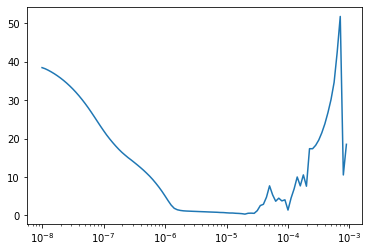

In [58]:
plt.semilogx(history.history["lr"], history.history["loss"])

In [59]:
tf.keras.backend.clear_session()
train_set = windowed_dataset(x_train, window_size, batch_size=250, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500)

Epoch 1/500
8/8 [==============================] - 3s 74ms/step - loss: 0.6839 - mae: 1.0899
Epoch 2/500
8/8 [==============================] - 1s 79ms/step - loss: 0.3187 - mae: 0.6432
Epoch 3/500
8/8 [==============================] - 1s 78ms/step - loss: 0.2456 - mae: 0.5563
Epoch 4/500
8/8 [==============================] - 1s 74ms/step - loss: 0.2058 - mae: 0.5004
Epoch 5/500
8/8 [==============================] - 1s 77ms/step - loss: 0.1820 - mae: 0.4710
Epoch 6/500
8/8 [==============================] - 1s 76ms/step - loss: 0.1807 - mae: 0.4744
Epoch 7/500
8/8 [==============================] - 1s 73ms/step - loss: 0.1682 - mae: 0.4496
Epoch 8/500
8/8 [==============================] - 1s 69ms/step - loss: 0.1644 - mae: 0.4398
Epoch 9/500
8/8 [==============================] - 1s 72ms/step - loss: 0.1606 - mae: 0.4322
Epoch 10/500
8/8 [==============================] - 1s 76ms/step - loss: 0.1577 - mae: 0.4285
Epoch 11/500
8/8 [==============================] - 1s 78ms/step - lo

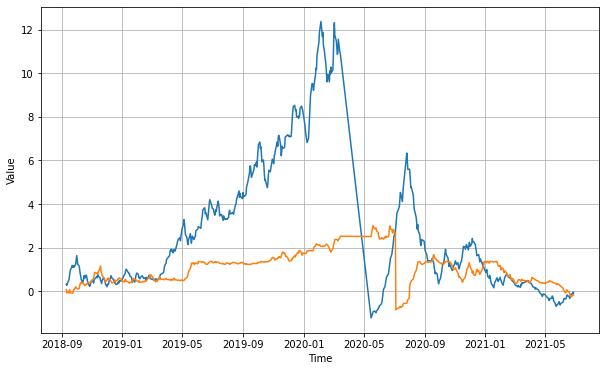

In [60]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [61]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

array([2.7272305, 2.8480692, 2.7894902, 2.856384 , 2.7424433, 2.7310257,
       2.8398032, 2.8516326, 2.8599474, 2.7729268, 2.7196736, 2.725965 ,
       2.6266482, 2.6611602, 2.673571 , 2.7046552, 2.687204 , 2.5833344,
       2.5271332, 2.490247 , 2.5007856, 2.5026875, 2.515547 , 2.5676355,
       2.5884972, 2.554411 , 2.537136 , 2.5359745, 2.5022109, 2.4886415,
       2.483417 , 2.493714 , 2.4778147, 2.439411 , 2.4099638, 2.3774176,
       2.3488004, 2.320403 , 2.3292117, 2.3293443, 2.3219757, 2.3283007,
       2.3126194, 2.2941754, 2.2827728, 2.3156648, 2.3245966, 2.3454096,
       2.374977 , 2.396492 , 2.4300334, 2.4732819, 2.4197316, 2.392305 ,
       2.4183424, 2.3862073, 2.3997183, 2.4315095, 2.4627764, 2.4789116,
       2.5030692, 2.4951053, 2.4753158, 2.4403327, 2.454796 , 2.475627 ,
       2.438181 , 2.4271045, 2.402894 , 2.4120736, 2.384405 , 2.3838944,
       2.4010239, 2.4099638, 2.445376 , 2.4466496, 2.4784417, 2.4456942,
       2.4104888, 2.4412656, 2.454796 , 2.4816017, 

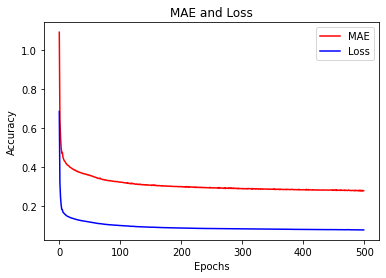

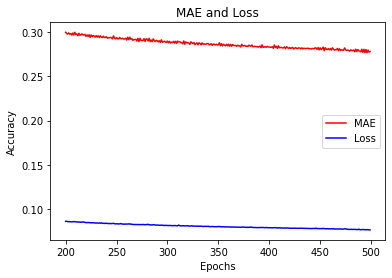

In [62]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])